In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import argrelextrema

def invert_image(image):
    return 255 - image

# Toy example for the classical Kalman Filter

## Continuous time signals $s_1(t) = cos(t)$ and $s_2(t) = cos(2t)$

## Sampling $s(t)$ 

sampling time step dt      = 0.1 s
sampling frequency step df = 10.0 Hz
N = 200 samples


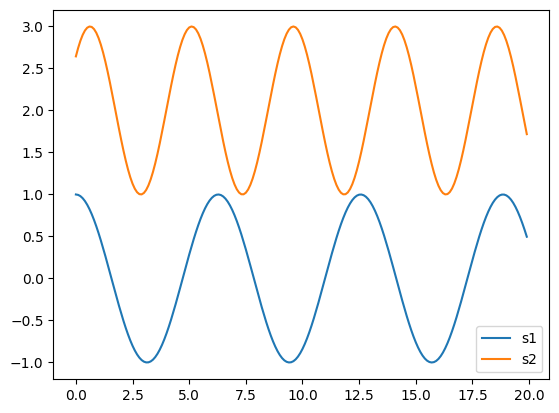

In [2]:
dt = 0.1   # Time step
N = 200    # Number of samples

print('sampling time step dt      =', dt, 's')
print('sampling frequency step df =', 1/dt, 'Hz')
print('N =', N, 'samples')

t = np.arange(0, N * dt, dt)  # Generates n points
s1 = np.cos(t)
s2 = np.sin(1.4*t + 0.7)
signals = np.array([s1, s2])

plt.plot(t, s1, label='s1') 
plt.plot(t, s2+2, label='s2')
plt.legend()
plt.show()

## Drawing signal $s$ in a pixel grid to create a raster image

In [3]:
### Parameters

# size of the pixels grid
height = 100
width = 200

# margins
t_margin = 7
l_margin = 0
r_margin = 0
b_margin = 7

line_thickness = 1 # pixels

overlap_percentages = [0, 0.1, 0.2, 0.3]
###

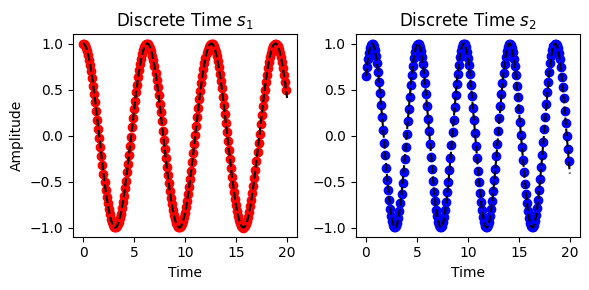

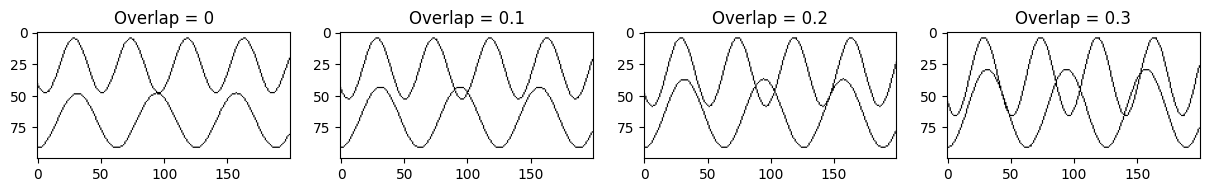

In [4]:
images = []
for overlap_percentage in overlap_percentages:
    background = np.full((height, width), 255, dtype=np.int32)  # background of binary image

    num_signals = len(signals)
            
    available_height = height - t_margin - b_margin  # Space available for signals
    max_amplitude = (available_height / num_signals) / (1 - overlap_percentage)  # Control overlap
            
    # Create vertical offsets while considering margins and overlap
    vertical_offsets = np.linspace(t_margin + max_amplitude / 2, height - b_margin - max_amplitude / 2, num_signals)
            
    # Horizontal shifting
    available_width = width - l_margin - r_margin
    horizontal_offsets = l_margin
    for i, signal in enumerate(signals):
        # Center, normalize and scale signal
        signal = (signal - np.mean(signal)) / np.max(np.abs(signal))  # Center and normalize
        scaled_signal = (max_amplitude / 2) * signal + vertical_offsets[len(signals)-1-i]  # Rescale amplitude to fit within frame
        # scaled_signal = available_height - scaled_signal
                
        # Create x-coordinates for plotting with horizontal offset
        x_coords = np.linspace(0, available_width - 1, len(signal)).astype(np.int32) + horizontal_offsets
        y_coords = scaled_signal.astype(np.int32)  # Ensure y-coordinates stay in bounds
                
        # plt.scatter(x_coords, y_coords, color='r')
        # plt.show()

        # Draw 
        for j in range(1, len(x_coords)):
            cv2.line(background, (x_coords[j-1], y_coords[j-1]), (x_coords[j], y_coords[j]), 0, line_thickness)

    images.append(background)

images = np.array(images)

# Display the images
fig1, ax1 = plt.subplots(1, 2, figsize=(6, 3))

ax1[0].scatter(t, s1, color='r')
ax1[0].set_title('Discrete Time $s_1$')
ax1[0].set_xlabel('Time')
ax1[0].set_ylabel('Amplitude')
ax1[0].plot(np.linspace(0, N*dt, 1000), np.cos(np.linspace(0, N*dt, 1000)), linestyle='--', color='k')

ax1[1].scatter(t, s2, color='b')
ax1[1].set_title('Discrete Time $s_2$')
ax1[1].set_xlabel('Time')
# ax1[1].set_ylabel('Amplitude')
ax1[1].plot(np.linspace(0, N*dt, 1000), np.sin(1.4*np.linspace(0, N*dt, 1000)+0.7), linestyle='--', color='k')

fig1.tight_layout()

fig2, ax2 = plt.subplots(1, len(images), figsize=(15, 8))
for i, image in enumerate(images):
    ax2[i].set_title('Overlap = ' + str(overlap_percentages[i]))
    ax2[i].imshow(image, cmap='gray', vmin=0, vmax=255)
    # ax2[i].axis('off')
# Show the plot
plt.show()

In [5]:
inverted_images = np.array([invert_image(image) for image in images]) / np.max(images)
all_x_0 = np.array([[1, 59], [1, 55], [1, 49], [1, 42]])

for inverted_image in inverted_images:
    print(np.where(inverted_image[:, 0] > 1e-16))
    # # find the len(signals) local maxima of inverted_image[:, 0] using argrelextrema
    # min_indices = argrelextrema(inverted_image[:, 0], np.less, order=1)[0]
    # print(min_indices)
    # # sorted_minima = min_indices[np.argsort(inverted_image[min_indices])]

(array([41, 42, 91], dtype=int64),)
(array([44, 45, 91], dtype=int64),)
(array([49, 50, 91], dtype=int64),)
(array([55, 56, 91], dtype=int64),)


## Implement the KF on the raster image

### State Transition Model

The state at time $k$ is defined as the 4D vector 
$$
\mathbf{x}_k = \begin{bmatrix} p v \end{bmatrix}
$$
where:
- $p$ is the position in the vertical direction.
- $v$ is the velocity in the vertical direction.

Note that the vertical direction corresponds to the vertical axe of the raster image.

The state transition model for a constant velocity motion in 2D is given by:
$$
\mathbf{x}_{k+1} = \mathbf{A} \mathbf{x}_k + \mathbf{w}_k
$$
Where:
- $\mathbf{x}_{k+1}$ is the state at time $k+1$.
- $\mathbf{x}_k$ is the state at time $k$.
- $\mathbf{A}$ is the state transition matrix.
- $\mathbf{w}_k \sim \mathcal{N}(\mathbf{0}, \mathbf{Q})$ is the process noise at time $k$.

The measurement model is:
$$
\mathbf{z}_k = \mathbf{H} \mathbf{x}_k + \mathbf{v}_k
$$
Where:
- $\mathbf{z}_k$ is the measurement at time $k$.
- $\mathbf{H}$ is the measurement matrix.
- $\mathbf{v}_k \sim \mathcal{N}(\mathbf{0}, \mathbf{R})$ is the measurement noise at time $k$.

Both $\mathbf{w}_k$ and $\mathbf{v}_k$ are white noise processes.

### Prediction and Update for Kalman Filter

1. **Prediction Step:**

The prediction step involves predicting the state at time $k+1$ using the state at time $k$ and the state transition model.

- **Predicted state estimate:**
$$
\hat{\mathbf{x}}_{k+1|k} = \mathbf{A} \hat{\mathbf{x}}_{k|k}
$$

- **Predicted covariance estimate:**
$$
\mathbf{P}_{k+1|k} = \mathbf{A} \mathbf{P}_{k|k} \mathbf{A}^T + \mathbf{Q}
$$
Where:
- $\hat{\mathbf{x}}_{k+1|k}$ is the predicted state estimate.
- $\mathbf{P}_{k+1|k}$ is the predicted covariance estimate.
- $\mathbf{P}_{k|k}$ is the current state covariance estimate.

2. **Update Step:**

Once a new measurement $\mathbf{z}_k$ is available, the update step corrects the predicted state and covariance.

- **Kalman Gain:**
$$
\mathbf{K}_k = \mathbf{P}_{k|k-1} \mathbf{H}^T \left( \mathbf{H} \mathbf{P}_{k|k-1} \mathbf{H}^T + \mathbf{R} \right)^{-1}
$$
Where:
- $\mathbf{K}_k$ is the Kalman gain.

- **Updated state estimate:**
$$
\hat{\mathbf{x}}_{k|k} = \hat{\mathbf{x}}_{k|k-1} + \mathbf{K}_k \left( \mathbf{z}_k - \mathbf{H} \hat{\mathbf{x}}_{k|k-1} \right)
$$

- **Updated covariance estimate:**
$$
\mathbf{P}_{k|k} = \left( \mathbf{I} - \mathbf{K}_k \mathbf{H} \right) \mathbf{P}_{k|k-1}
$$

Where:
- $\hat{\mathbf{x}}_{k|k}$ is the updated state estimate.
- $\mathbf{P}_{k|k}$ is the updated covariance estimate.
- $\mathbf{I}$ is the identity matrix.

#### Choice of $\Delta t$

Assuming no corruption of the time axis of the raster image (the horizontal axis), the formula is:
$$ \Delta t = \frac{\text{available\_width}}{N_{\text{samples}} - 1} $$

In our case, $$\Delta t = 1 \quad \text{pixels}$$.

In [6]:
# Define the system dynamics

### Parameters
Dts = [1] # Time step related to the state transition matrix A, ! different than sampling rate dt of signal s

# Assuming no process noise
sigma_ps = [1, 1e-1, 1e-2]
sigma_vs = [1, 1.5, 1e-2]
sigma_as = [1, 1e-1, 1e-2]

# Assuming no measurement noise
sigma_zs = [1e-6, 1e-2, 1e-4]
###

In [7]:
# Define the prediction step
def predict(X, P, A, Q):
    # check if X has 1 or 2 dimension(s)
    if len(X.shape) == 1:
        X = A @ X
        P = A @ P @ A.T + Q
    else:
        for i in range(X.shape[0]):
            X[i] = A @ X[i]
            P[i] = A @ P[i] @ A.T + Q
        # X = (A @ X.T).T  # Batch multiply all rows of X at once
        # P = A @ P @ A.T + Q  # Assuming P is (N, M, M), use batch multiplication
    return X, P

def update(x, P, z, H, R):
    S = H @ P @ H.T + R
    K = P @ H.T @ np.linalg.inv(S)
    x = x + K @ (z - H @ x)
    P = P - K @ H @ P
    return x, P

In [8]:
def weighted_update(X, P, Z, H, R, P_fa=0):
    """
    Perform the Kalman filter update step using the JPDA approach for multiple traces.

    Args:
        X (np.ndarray): Shape (N, n) - Predicted state estimates for N traces.
        P (np.ndarray): Shape (N, n, n) - Predicted covariance matrices for N traces.
        Z (np.ndarray): Shape (M, m) - Measurements for M detections, m=1.
        H (np.ndarray): Shape (m, n) - Observation matrix.
        R (np.ndarray): Shape (m, m) - Measurement noise covariance, m=1.

    Returns:
        X_updated (np.ndarray): Shape (N, n) - Updated state estimates.
        P_updated (np.ndarray): Shape (N, n, n) - Updated covariance matrices.
    """
    # print("X : ", type(X[0,0]))
    # print("P : ", type(P[0,0,0]))
    # print("Z : ", type(Z[0]))
    # print("H : ", type(H[0,0]))
    # print("R : ", type(R[0,0]))
    N, n = X.shape  # Number of traces, state dimension
    M = Z.shape[0]      # Number of measurements
    # m = Z.shape[1]      # Measurement dimension
    m = 1
    
    X_updated = np.copy(X)
    P_updated = np.copy(P)
    
    # Compute innovation covariance and Kalman gains
    S = np.zeros((N, m, m))  # Innovation covariance for each trace
    K = np.zeros((N, n, m))  # Kalman gain for each trace
    for i in range(N):
        S[i] = H @ P[i] @ H.T + R               # Innovation covariance
        # print(i, S[i], K[i])
        K[i] = P[i] @ H.T @ np.linalg.inv(S[i]) # Kalman gain

    # Compute association probabilities β_ij using Mahalanobis distance
    beta = np.zeros((N, M))
    likelihoods = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            residual = Z[j] - H @ X[i]  # Innovation (measurement residual)
            # print('res',i, j, residual)
            mahalanobis_dist = residual.T @ np.linalg.inv(S[i]) @ residual  # Mahalanobis distance
            # print(i, j, mahalanobis_dist)
            likelihoods[i, j] = np.exp(-0.5 * mahalanobis_dist) / np.sqrt((2*np.pi)**m*np.linalg.det(S[i]))
            # print(i, j, likelihoods[i, j],"-",  np.exp(-0.5 * mahalanobis_dist),"-", -0.5*mahalanobis_dist )

    # Normalize probabilities
    # print("lik", likelihoods)
    for i in range(N):
        beta[i, :] = likelihoods[i, :] / (np.sum(likelihoods[i, :]) + P_fa)  # Avoid division by zero

    # Update states using weighted innovation
    for i in range(N):
        weighted_innovation = np.zeros((m, 1))
        for j in range(M):
            weighted_innovation += beta[i, j] * (Z[j] - H @ X[i])
        # Update state and covariance
        beta_i = np.sum(beta[i, :])
        X_updated[i] = X[i] + (K[i] @ weighted_innovation).ravel() # ! Check if this is correct
        temp = (np.eye(n) - beta_i * K[i] @ H)
        P_updated[i] = temp @ P[i] @ temp.T + K[i] @ (np.sum(beta[i, :]**2) * R) @ K[i].T


    return X_updated, P_updated, beta

Dt = 1 sigma_p = 1 sigma_v = 1 sigma_z = 1e-06 sigma_a = 1


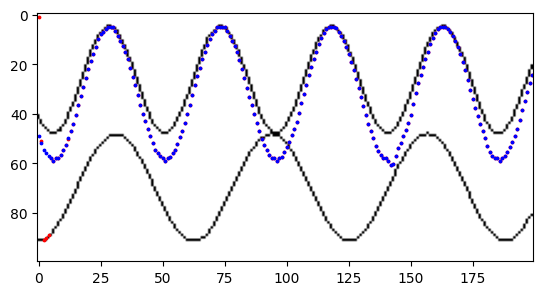

Dt = 1 sigma_p = 1 sigma_v = 1 sigma_z = 1e-06 sigma_a = 0.1


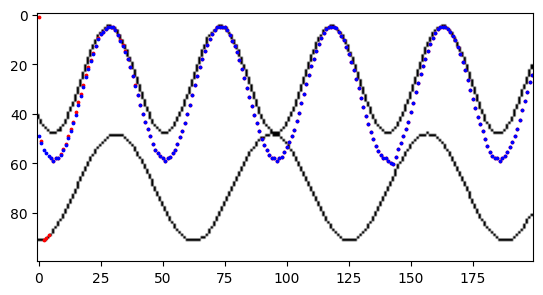

Dt = 1 sigma_p = 1 sigma_v = 1 sigma_z = 1e-06 sigma_a = 0.01


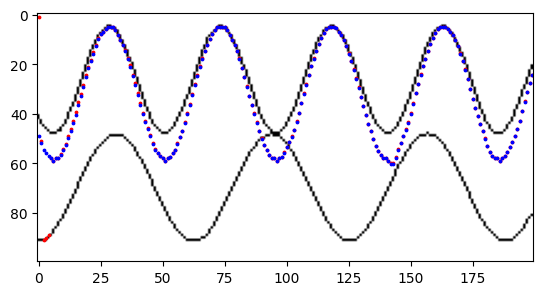

Dt = 1 sigma_p = 1 sigma_v = 1 sigma_z = 0.01 sigma_a = 1


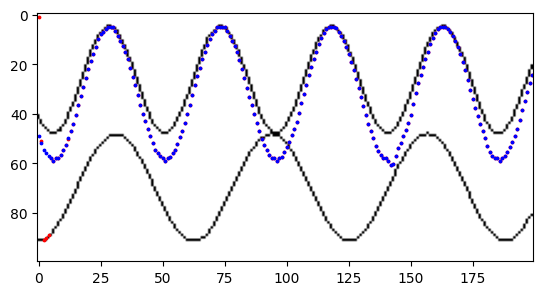

Dt = 1 sigma_p = 1 sigma_v = 1 sigma_z = 0.01 sigma_a = 0.1


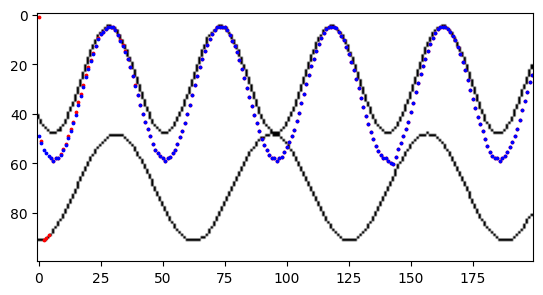

Dt = 1 sigma_p = 1 sigma_v = 1 sigma_z = 0.01 sigma_a = 0.01


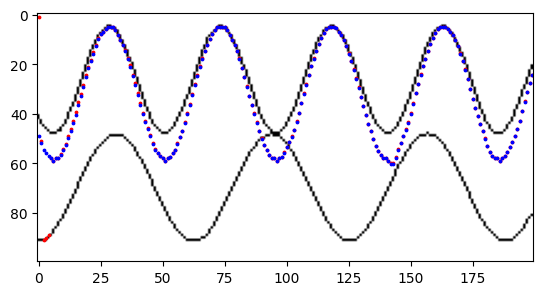

Dt = 1 sigma_p = 1 sigma_v = 1 sigma_z = 0.0001 sigma_a = 1


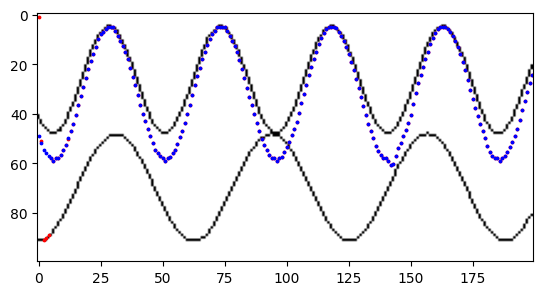

Dt = 1 sigma_p = 1 sigma_v = 1 sigma_z = 0.0001 sigma_a = 0.1


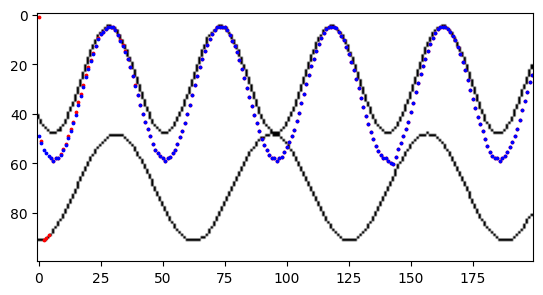

Dt = 1 sigma_p = 1 sigma_v = 1 sigma_z = 0.0001 sigma_a = 0.01


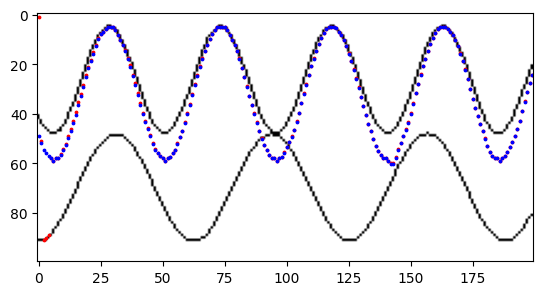

Dt = 1 sigma_p = 1 sigma_v = 1.5 sigma_z = 1e-06 sigma_a = 1


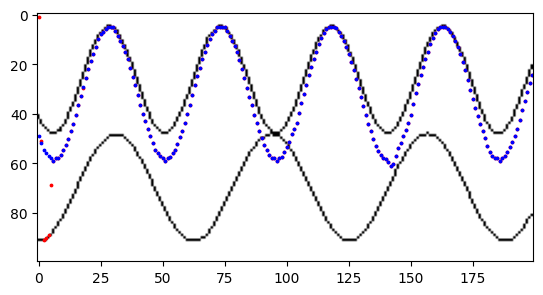

Dt = 1 sigma_p = 1 sigma_v = 1.5 sigma_z = 1e-06 sigma_a = 0.1


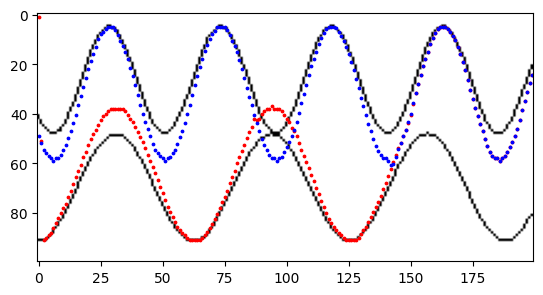

Dt = 1 sigma_p = 1 sigma_v = 1.5 sigma_z = 1e-06 sigma_a = 0.01


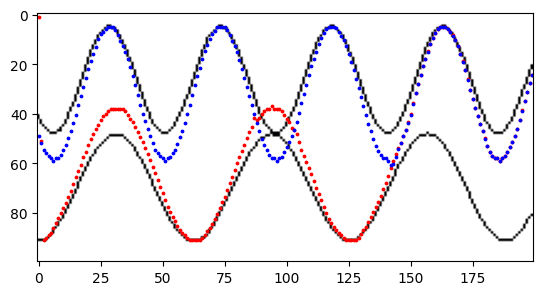

Dt = 1 sigma_p = 1 sigma_v = 1.5 sigma_z = 0.01 sigma_a = 1


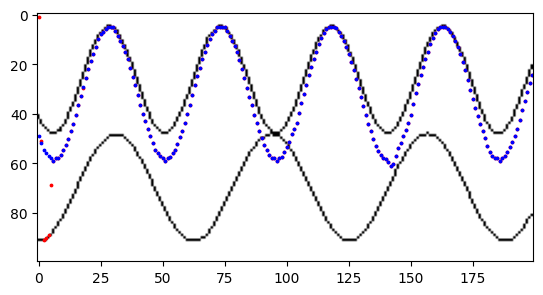

Dt = 1 sigma_p = 1 sigma_v = 1.5 sigma_z = 0.01 sigma_a = 0.1


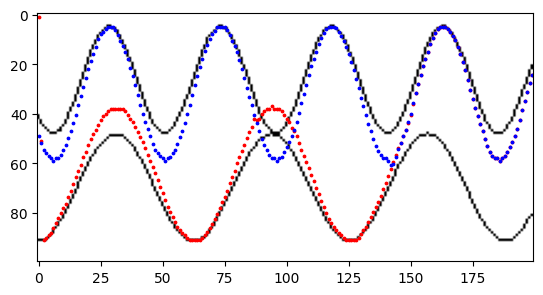

Dt = 1 sigma_p = 1 sigma_v = 1.5 sigma_z = 0.01 sigma_a = 0.01


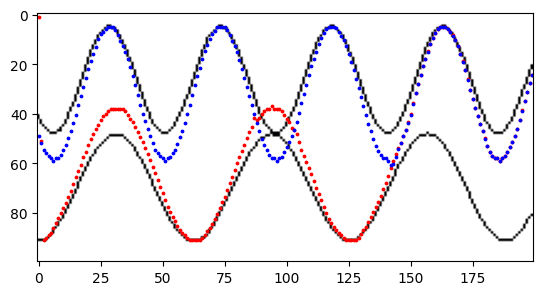

Dt = 1 sigma_p = 1 sigma_v = 1.5 sigma_z = 0.0001 sigma_a = 1


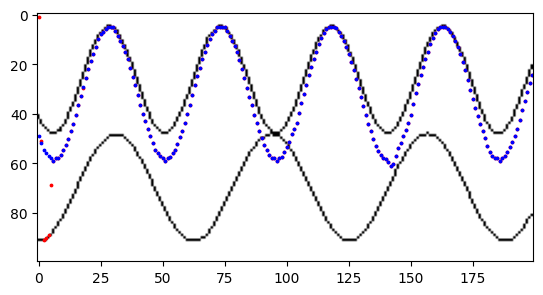

Dt = 1 sigma_p = 1 sigma_v = 1.5 sigma_z = 0.0001 sigma_a = 0.1


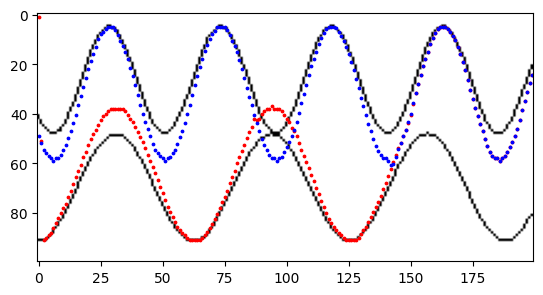

Dt = 1 sigma_p = 1 sigma_v = 1.5 sigma_z = 0.0001 sigma_a = 0.01


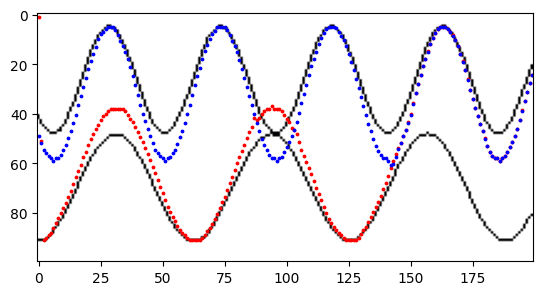

Dt = 1 sigma_p = 1 sigma_v = 0.01 sigma_z = 1e-06 sigma_a = 1


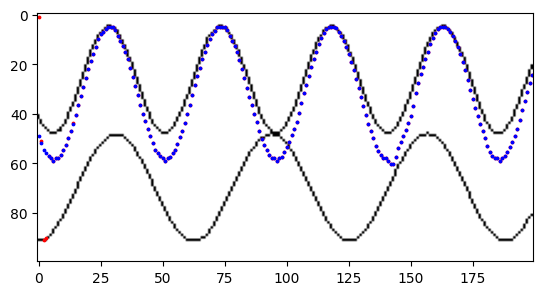

Dt = 1 sigma_p = 1 sigma_v = 0.01 sigma_z = 1e-06 sigma_a = 0.1


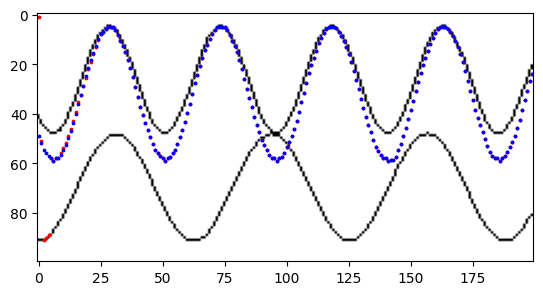

Dt = 1 sigma_p = 1 sigma_v = 0.01 sigma_z = 1e-06 sigma_a = 0.01


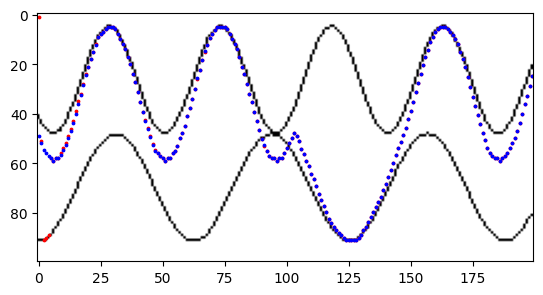

Dt = 1 sigma_p = 1 sigma_v = 0.01 sigma_z = 0.01 sigma_a = 1


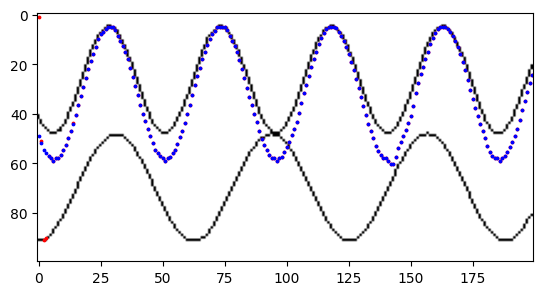

Dt = 1 sigma_p = 1 sigma_v = 0.01 sigma_z = 0.01 sigma_a = 0.1


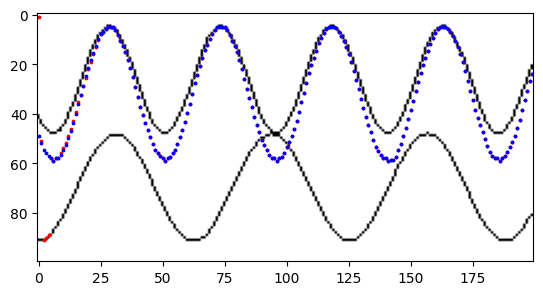

Dt = 1 sigma_p = 1 sigma_v = 0.01 sigma_z = 0.01 sigma_a = 0.01


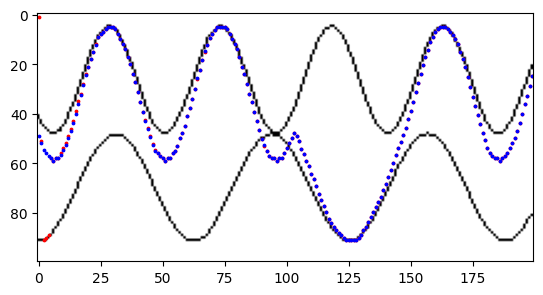

Dt = 1 sigma_p = 1 sigma_v = 0.01 sigma_z = 0.0001 sigma_a = 1


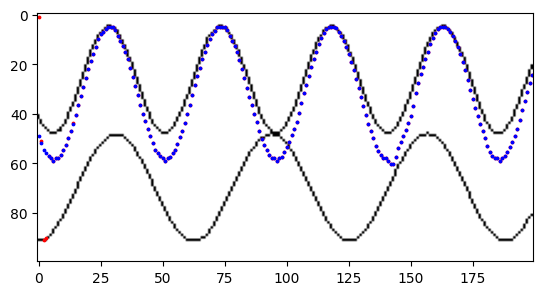

Dt = 1 sigma_p = 1 sigma_v = 0.01 sigma_z = 0.0001 sigma_a = 0.1


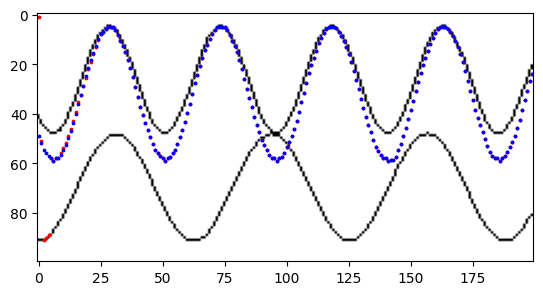

Dt = 1 sigma_p = 1 sigma_v = 0.01 sigma_z = 0.0001 sigma_a = 0.01


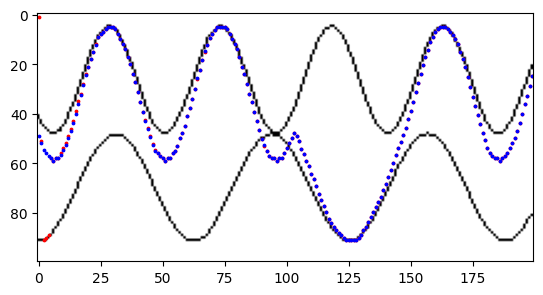

Dt = 1 sigma_p = 0.1 sigma_v = 1 sigma_z = 1e-06 sigma_a = 1


C:\Users\Colin\AppData\Local\Temp\ipykernel_14180\4078342524.py:52: RuntimeWarning: invalid value encountered in divide
  beta[i, :] = likelihoods[i, :] / (np.sum(likelihoods[i, :]) + P_fa)  # Avoid division by zero
c:\Users\Colin\miniconda3\envs\seismo_env\Lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


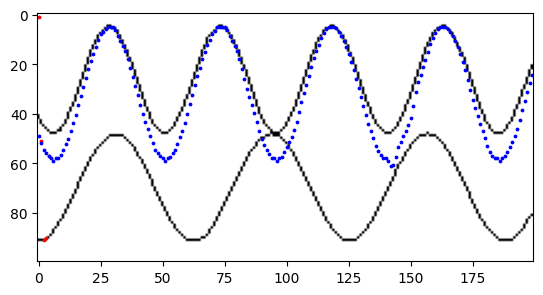

Dt = 1 sigma_p = 0.1 sigma_v = 1 sigma_z = 1e-06 sigma_a = 0.1


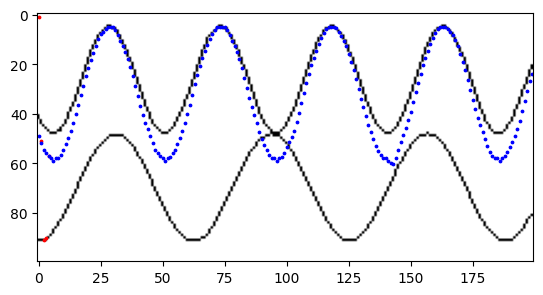

Dt = 1 sigma_p = 0.1 sigma_v = 1 sigma_z = 1e-06 sigma_a = 0.01


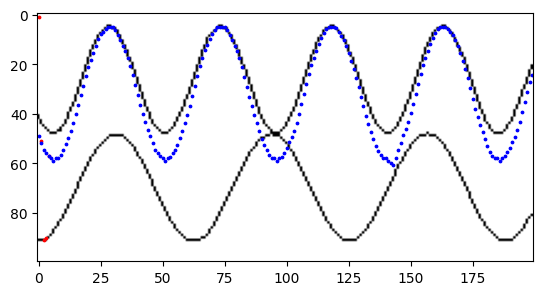

Dt = 1 sigma_p = 0.1 sigma_v = 1 sigma_z = 0.01 sigma_a = 1


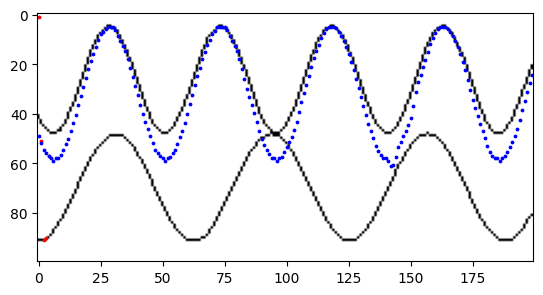

Dt = 1 sigma_p = 0.1 sigma_v = 1 sigma_z = 0.01 sigma_a = 0.1


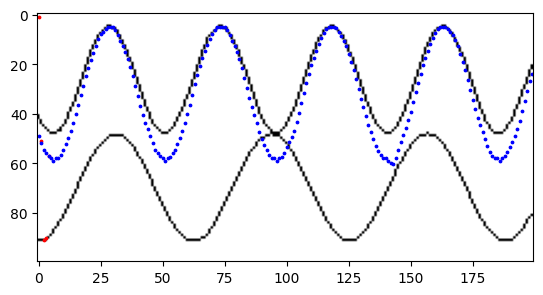

Dt = 1 sigma_p = 0.1 sigma_v = 1 sigma_z = 0.01 sigma_a = 0.01


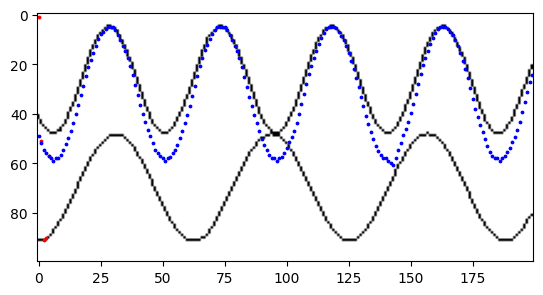

Dt = 1 sigma_p = 0.1 sigma_v = 1 sigma_z = 0.0001 sigma_a = 1


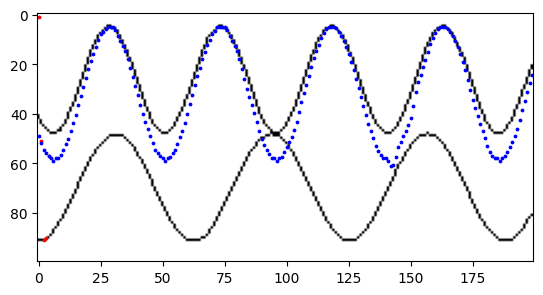

Dt = 1 sigma_p = 0.1 sigma_v = 1 sigma_z = 0.0001 sigma_a = 0.1


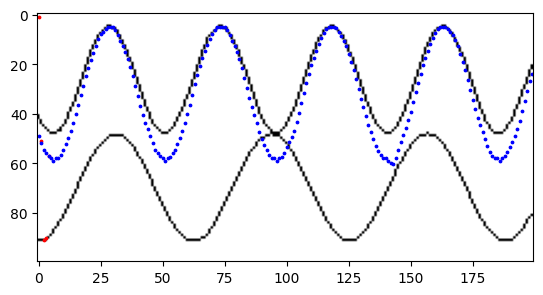

Dt = 1 sigma_p = 0.1 sigma_v = 1 sigma_z = 0.0001 sigma_a = 0.01


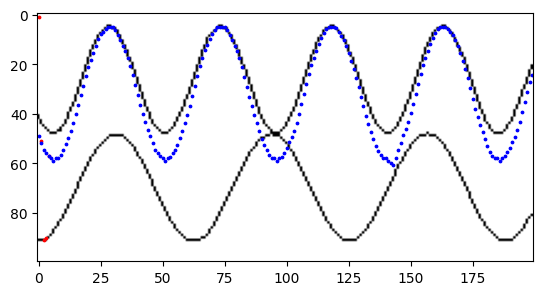

Dt = 1 sigma_p = 0.1 sigma_v = 1.5 sigma_z = 1e-06 sigma_a = 1


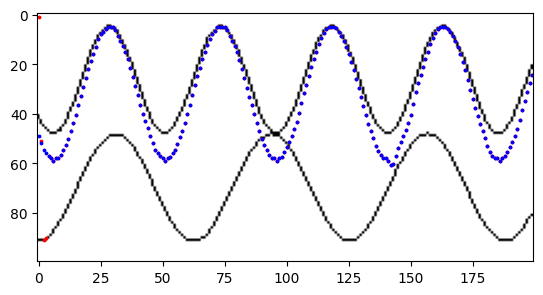

Dt = 1 sigma_p = 0.1 sigma_v = 1.5 sigma_z = 1e-06 sigma_a = 0.1


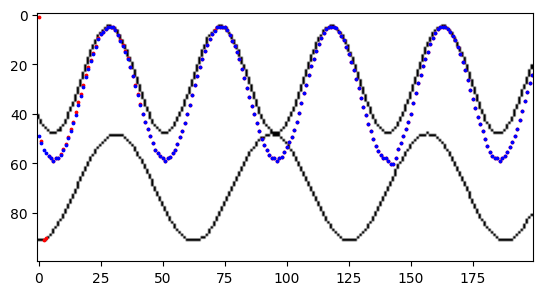

Dt = 1 sigma_p = 0.1 sigma_v = 1.5 sigma_z = 1e-06 sigma_a = 0.01


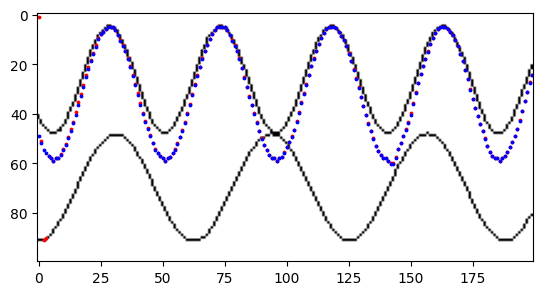

Dt = 1 sigma_p = 0.1 sigma_v = 1.5 sigma_z = 0.01 sigma_a = 1


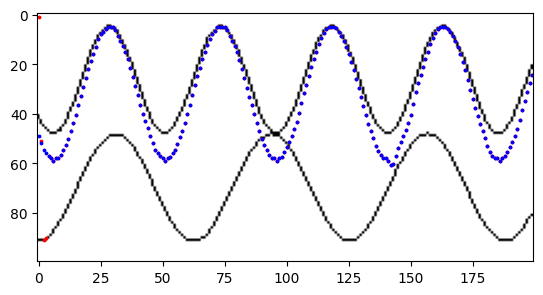

Dt = 1 sigma_p = 0.1 sigma_v = 1.5 sigma_z = 0.01 sigma_a = 0.1


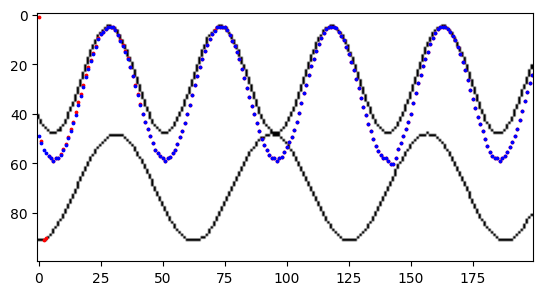

Dt = 1 sigma_p = 0.1 sigma_v = 1.5 sigma_z = 0.01 sigma_a = 0.01


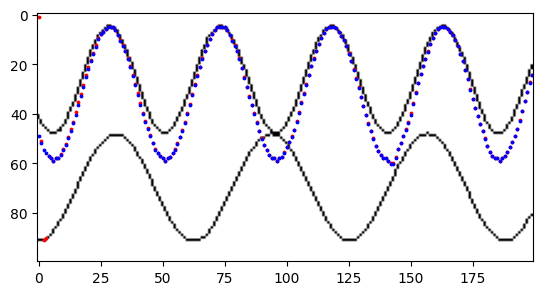

Dt = 1 sigma_p = 0.1 sigma_v = 1.5 sigma_z = 0.0001 sigma_a = 1


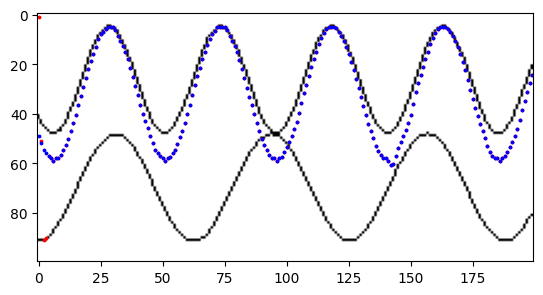

Dt = 1 sigma_p = 0.1 sigma_v = 1.5 sigma_z = 0.0001 sigma_a = 0.1


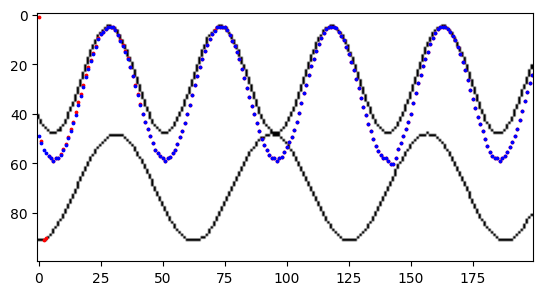

Dt = 1 sigma_p = 0.1 sigma_v = 1.5 sigma_z = 0.0001 sigma_a = 0.01


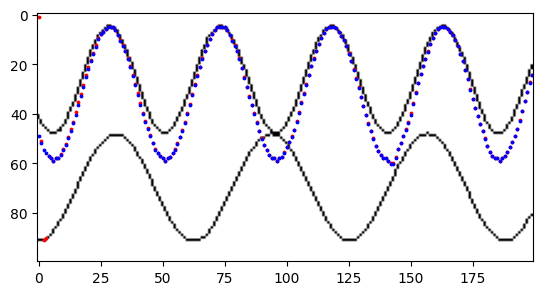

Dt = 1 sigma_p = 0.1 sigma_v = 0.01 sigma_z = 1e-06 sigma_a = 1


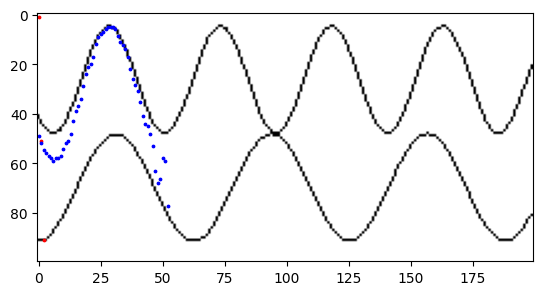

Dt = 1 sigma_p = 0.1 sigma_v = 0.01 sigma_z = 1e-06 sigma_a = 0.1


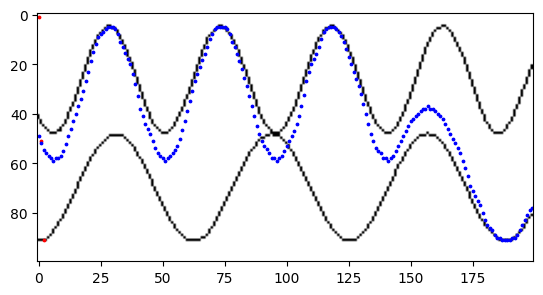

Dt = 1 sigma_p = 0.1 sigma_v = 0.01 sigma_z = 1e-06 sigma_a = 0.01


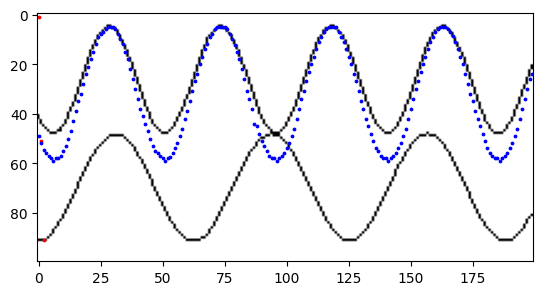

Dt = 1 sigma_p = 0.1 sigma_v = 0.01 sigma_z = 0.01 sigma_a = 1


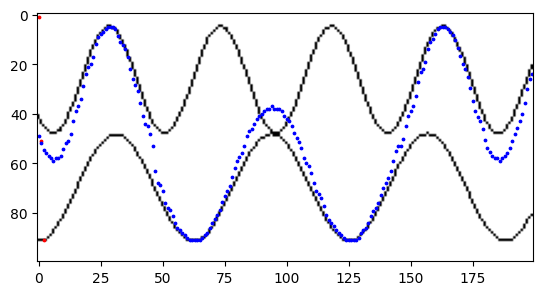

Dt = 1 sigma_p = 0.1 sigma_v = 0.01 sigma_z = 0.01 sigma_a = 0.1


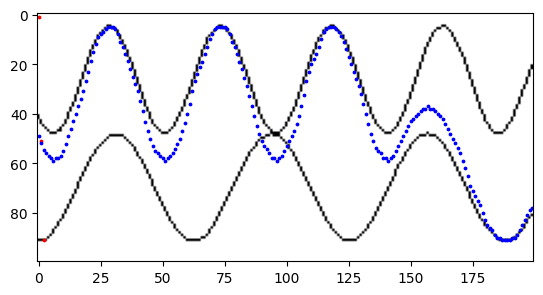

Dt = 1 sigma_p = 0.1 sigma_v = 0.01 sigma_z = 0.01 sigma_a = 0.01


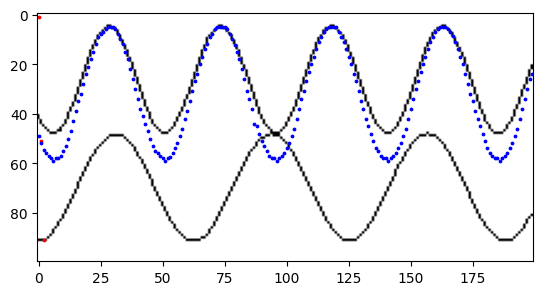

Dt = 1 sigma_p = 0.1 sigma_v = 0.01 sigma_z = 0.0001 sigma_a = 1


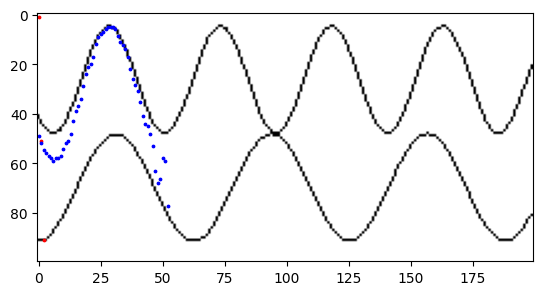

Dt = 1 sigma_p = 0.1 sigma_v = 0.01 sigma_z = 0.0001 sigma_a = 0.1


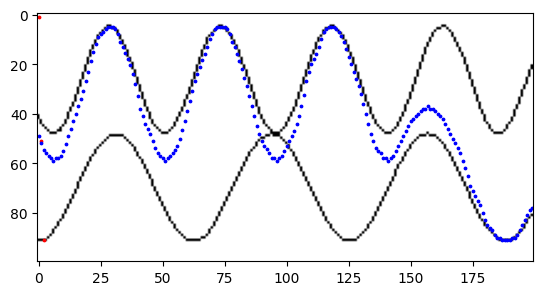

Dt = 1 sigma_p = 0.1 sigma_v = 0.01 sigma_z = 0.0001 sigma_a = 0.01


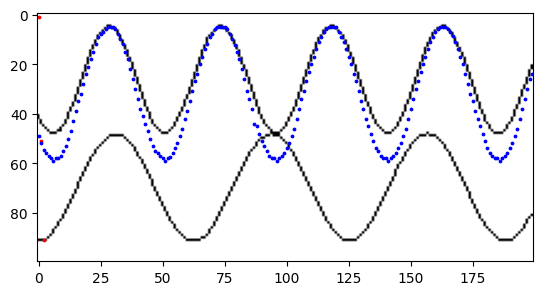

Dt = 1 sigma_p = 0.01 sigma_v = 1 sigma_z = 1e-06 sigma_a = 1


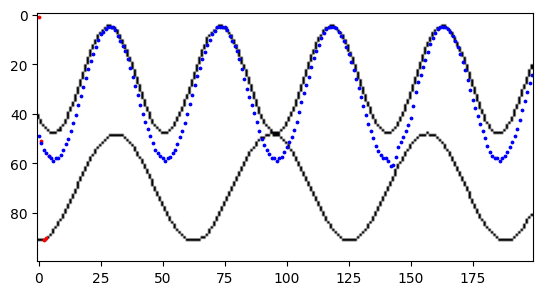

Dt = 1 sigma_p = 0.01 sigma_v = 1 sigma_z = 1e-06 sigma_a = 0.1


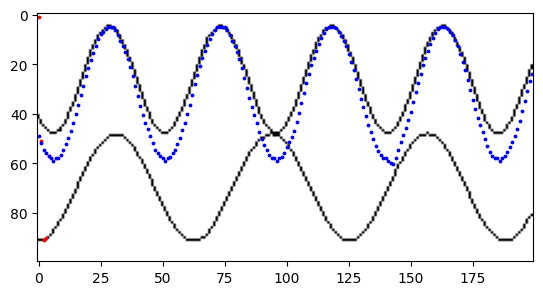

Dt = 1 sigma_p = 0.01 sigma_v = 1 sigma_z = 1e-06 sigma_a = 0.01


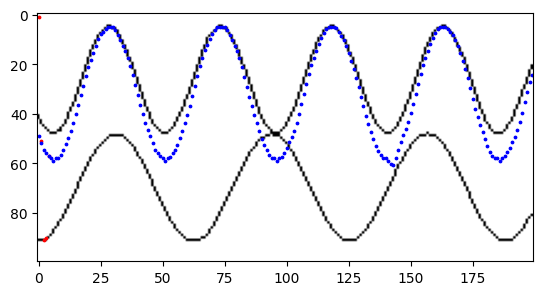

Dt = 1 sigma_p = 0.01 sigma_v = 1 sigma_z = 0.01 sigma_a = 1


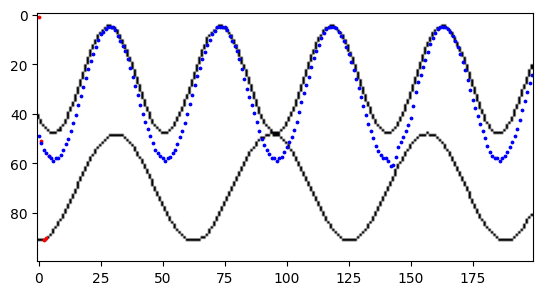

Dt = 1 sigma_p = 0.01 sigma_v = 1 sigma_z = 0.01 sigma_a = 0.1


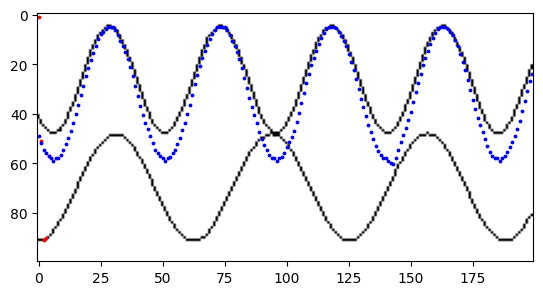

Dt = 1 sigma_p = 0.01 sigma_v = 1 sigma_z = 0.01 sigma_a = 0.01


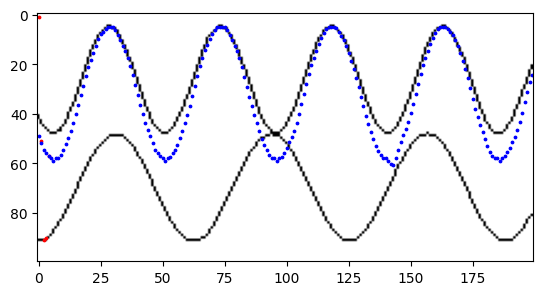

Dt = 1 sigma_p = 0.01 sigma_v = 1 sigma_z = 0.0001 sigma_a = 1


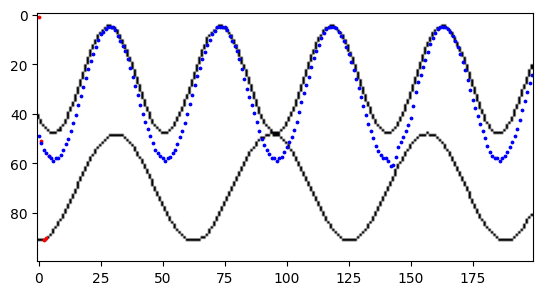

Dt = 1 sigma_p = 0.01 sigma_v = 1 sigma_z = 0.0001 sigma_a = 0.1


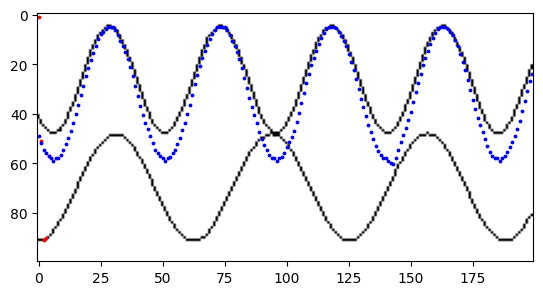

Dt = 1 sigma_p = 0.01 sigma_v = 1 sigma_z = 0.0001 sigma_a = 0.01


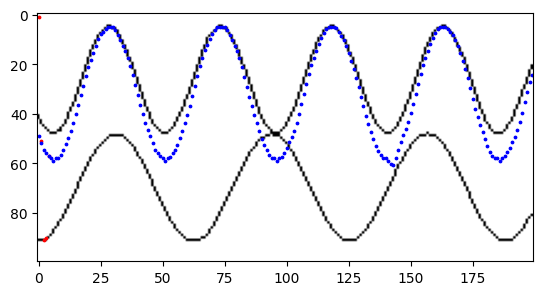

Dt = 1 sigma_p = 0.01 sigma_v = 1.5 sigma_z = 1e-06 sigma_a = 1


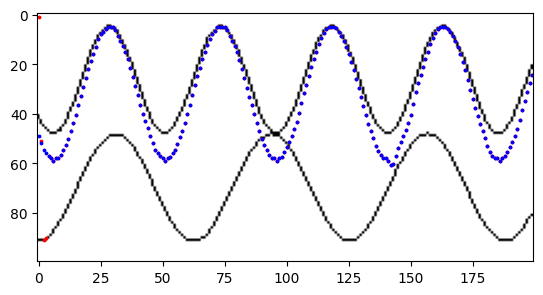

Dt = 1 sigma_p = 0.01 sigma_v = 1.5 sigma_z = 1e-06 sigma_a = 0.1


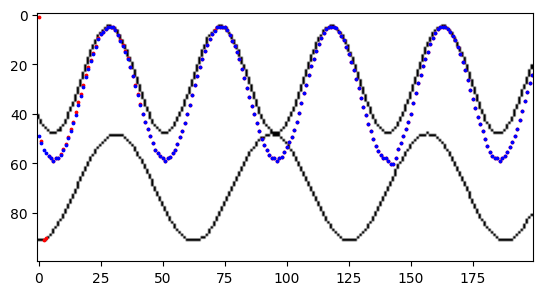

Dt = 1 sigma_p = 0.01 sigma_v = 1.5 sigma_z = 1e-06 sigma_a = 0.01


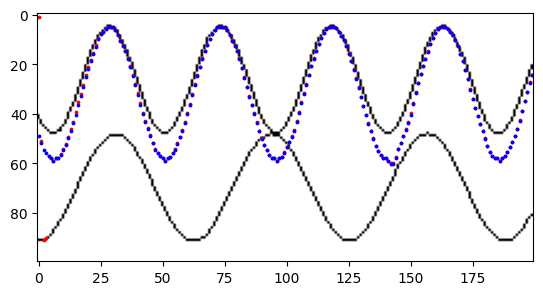

Dt = 1 sigma_p = 0.01 sigma_v = 1.5 sigma_z = 0.01 sigma_a = 1


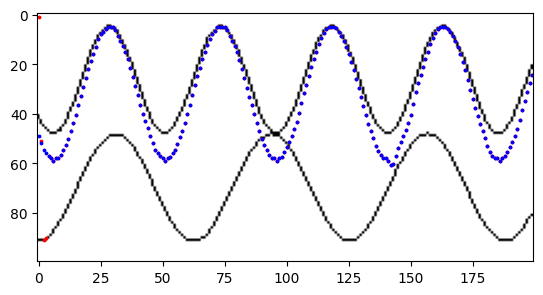

Dt = 1 sigma_p = 0.01 sigma_v = 1.5 sigma_z = 0.01 sigma_a = 0.1


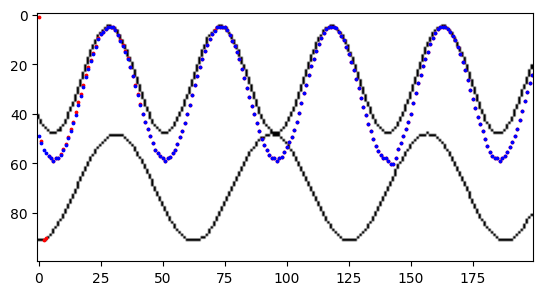

Dt = 1 sigma_p = 0.01 sigma_v = 1.5 sigma_z = 0.01 sigma_a = 0.01


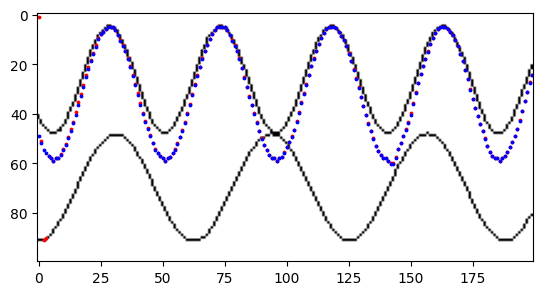

Dt = 1 sigma_p = 0.01 sigma_v = 1.5 sigma_z = 0.0001 sigma_a = 1


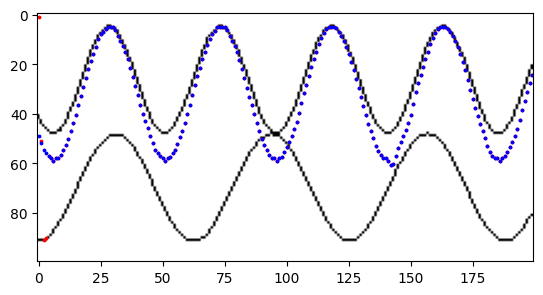

Dt = 1 sigma_p = 0.01 sigma_v = 1.5 sigma_z = 0.0001 sigma_a = 0.1


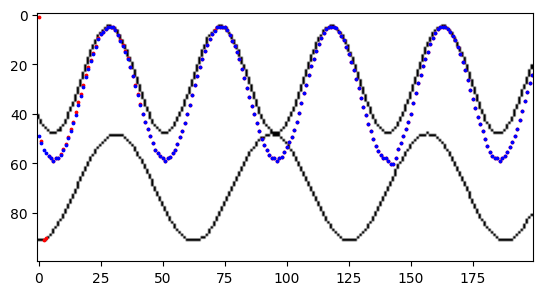

Dt = 1 sigma_p = 0.01 sigma_v = 1.5 sigma_z = 0.0001 sigma_a = 0.01


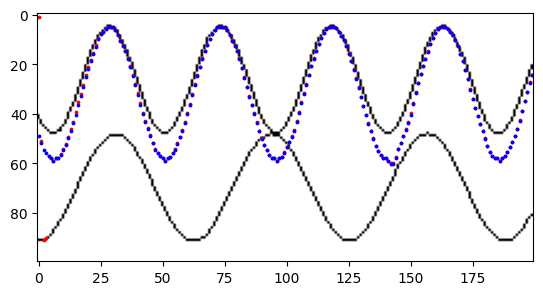

Dt = 1 sigma_p = 0.01 sigma_v = 0.01 sigma_z = 1e-06 sigma_a = 1


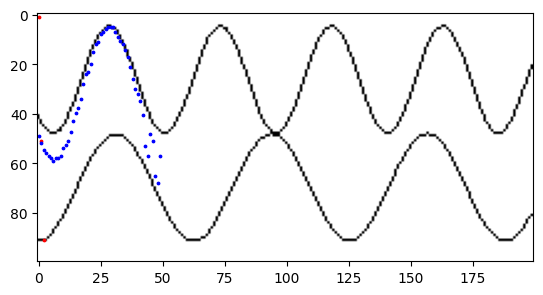

Dt = 1 sigma_p = 0.01 sigma_v = 0.01 sigma_z = 1e-06 sigma_a = 0.1


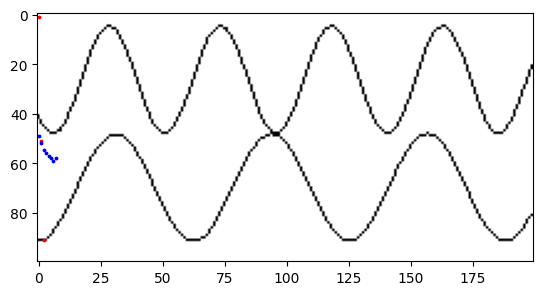

Dt = 1 sigma_p = 0.01 sigma_v = 0.01 sigma_z = 1e-06 sigma_a = 0.01


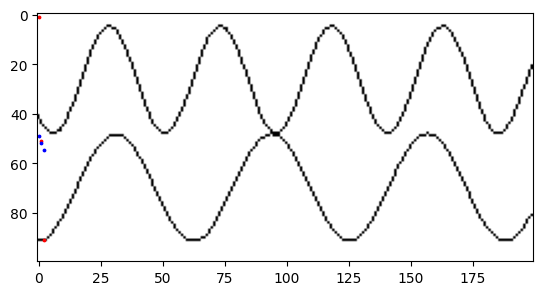

Dt = 1 sigma_p = 0.01 sigma_v = 0.01 sigma_z = 0.01 sigma_a = 1


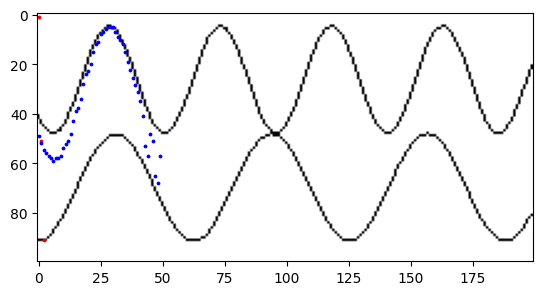

Dt = 1 sigma_p = 0.01 sigma_v = 0.01 sigma_z = 0.01 sigma_a = 0.1


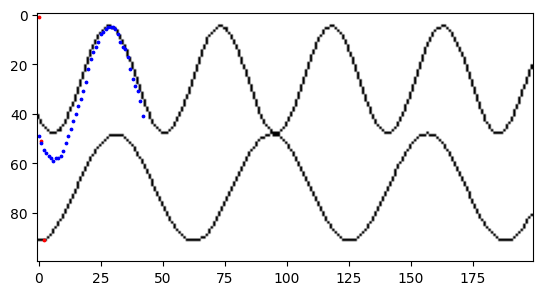

Dt = 1 sigma_p = 0.01 sigma_v = 0.01 sigma_z = 0.01 sigma_a = 0.01


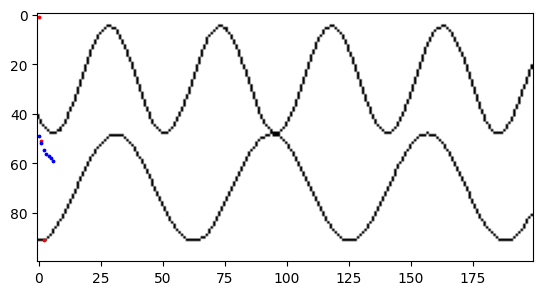

Dt = 1 sigma_p = 0.01 sigma_v = 0.01 sigma_z = 0.0001 sigma_a = 1


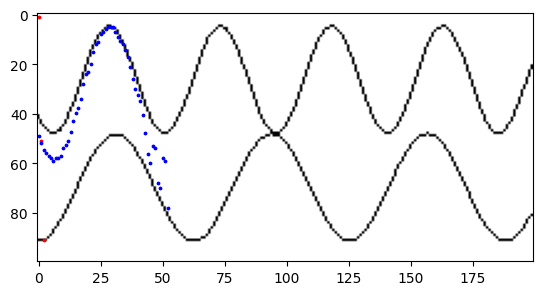

Dt = 1 sigma_p = 0.01 sigma_v = 0.01 sigma_z = 0.0001 sigma_a = 0.1


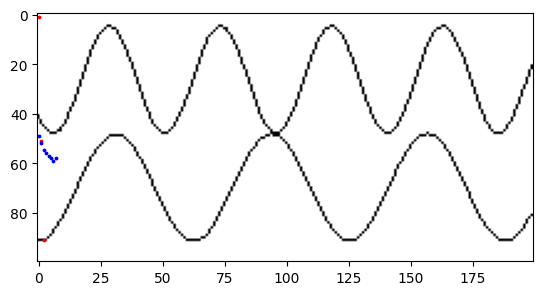

Dt = 1 sigma_p = 0.01 sigma_v = 0.01 sigma_z = 0.0001 sigma_a = 0.01


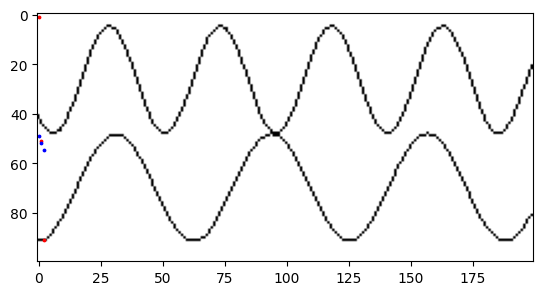

In [9]:
### 
# Weighted Kalman filter
###

for Dt in Dts:
    for sigma_p in sigma_ps:
        for sigma_v in sigma_vs:
            for sigma_z in sigma_zs:
                for sigma_a in sigma_as:
                    print('Dt =', Dt, "sigma_p =", sigma_p, "sigma_v =", sigma_v, "sigma_z =", sigma_z, "sigma_a =", sigma_a)

                    # A = np.array([[1, 0, Dt, 0],
                    #               [0, 1, 0, Dt],
                    #               [0, 0, 1, 0],
                    #               [0, 0, 0, 1]])
                    A = np.array([[1, Dt, Dt**2/2],
                                [0, 1, Dt],
                                [0, 0, 1]]).astype(np.float64)

                    # H = np.array([[1, 0, 0, 0],
                    #               [0, 1, 0, 0]])
                    H = np.array([[1, 0, 0]]).astype(np.float64)

                    Q = np.array([[sigma_p**2, 0, 0],
                                [0, sigma_v**2, 0],
                                [0, 0, sigma_a**2]])

                    R = np.array([[sigma_z**2]])

                    # Initial state covariance given all_x_0
                    P = np.zeros((3, 3))
                    P[1, 1] = 10
                    P[2, 2] = 5

                    x_0 = all_x_0[2]
                    X_weighted = np.array([[x_0[0], 0, 0], [x_0[1], 0, 0]]).astype(np.float64)
                    P_weighted = np.array([np.copy(P), np.copy(P)]).astype(np.float64)
                    tresh = 1e-2

                    image = inverted_images[2]

                    plt.imshow(images[0], cmap='gray')

                    # print(X_weighted)

                    avg_N_components = 2

                    estimated_positions_weighted = [[] for _ in range(avg_N_components)]
                    estimated_positions_weighted[0].append(X_weighted[0, 0])
                    estimated_positions_weighted[1].append(X_weighted[1, 0])

                    for k in range(1, image.shape[1]):
                        col = image[:, k]
                        # find the non 0 value pixels, with a given treshold
                        measurements = (np.where(col > tresh)[0]).astype(np.float64)

                        # Predict
                        X_w, P_w = predict(X_weighted, P_weighted, A, Q)
                        # Weighted Update
                        # print(measurements)
                        X_weighted, P_weighted, beta = weighted_update(X_w, P_w, measurements, H, R)
                        # print("beta", beta)
                        # print()
                        # X_weighted, P_weighted = (X_w, P_w)
                        # print(X_weighted)
                        for i in range(avg_N_components):
                            # Save the estimated position
                            estimated_positions_weighted[i].append(X_weighted[i, 0])
                    # print( estimated_positions_weighted[0])
                    # print(estimated_positions_weighted[1])

                    # valid_indices = ~np.isnan(estimated_positions_weighted[0])  # Get valid (non-NaN) indicesµ
                    # print(estimated_positions_weighted)
                    plt.scatter(np.arange(0, len(estimated_positions_weighted[0])), estimated_positions_weighted[0], color='r', s=3)
                    plt.scatter(np.arange(0, len(estimated_positions_weighted[1])), estimated_positions_weighted[1], color='b', s=3)

                    plt.show()